##  Data analysis

We consider data generated by our Ising model for set of temperature $T \in [1,3]$ on a 50x50 lattice. Glauber and Kawasaki dynamics are considered separately. Errors are considered for (magnetisation, energy and) the scaled heat capacity via the bootstrap or jacknife method.

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [202]:
def chi(M_data, N, kb, T):
    varM = (np.array(M_data)**2).mean() - (np.array(M_data).mean())**2
    return (1 / (N * kb * T)) * varM

def scaled_heat_capacity(E_data, N, kb, T):
    varE = (np.array(E_data)**2).mean() - (np.array(E_data).mean())**2
    return (1 / (N * kb * T**2)) * varE

def mean_STD(measurement):
    # Assumes measurements are uncorrelated
    n = len(measurement)
    return np.sqrt(((np.array(measurement)**2).mean() - (np.array(measurement).mean())**2) / (n-1))

def bootstrap(k, measurement, T, N, kb):
    n = len(measurement)
    resample_data = []
    for i in range(k):
        resampling = []
        for _ in range(n):
            resampling.append(measurement[np.random.randint(0, n)])
        c_resampled = scaled_heat_capacity(resampling, N, kb, T)
        resample_data.append(c_resampled)
    return np.sqrt((np.array(resample_data)**2).mean() - (np.array(resample_data).mean())**2)

def jacknife(measurement, T, N, kb):
    n = len(measurement)
    c = scaled_heat_capacity(measurement, N, kb, T)
    c_resampled = []
    for i in range(n):
        resampling = list(measurement[:i]) + list(measurement[(i+1):])
        c_resampled.apipend(scaled_heat_capacity(resampling, N, kb, T))
    return np.sqrt(n * ((np.array(c_resampled)**2).mean() - (np.array(c_resampled).mean())**2))

## Glauber dynamics

In [220]:
kb = 1
xlen = 50
ylen = 50
N = xlen * ylen

In [203]:
data = pd.read_csv('data50x50glauber_run2.csv', sep=',', converters={'energy data': pd.eval, 'magnetism data': pd.eval})
data.head()

,T,energy data,magnetism data
0,1.0,"[-4892.0, -4900.0, -4892.0, -4880.0, -4900.0, ...","[2498.0, 2500.0, 2498.0, 2494.0, 2500.0, 2496...."
1,1.1,"[-4900.0, -4876.0, -4884.0, -4868.0, -4892.0, ...","[2500.0, 2492.0, 2496.0, 2492.0, 2498.0, 2492...."
2,1.2,"[-4868.0, -4884.0, -4876.0, -4884.0, -4876.0, ...","[2492.0, 2496.0, 2494.0, 2496.0, 2494.0, 2488...."
3,1.3,"[-4860.0, -4844.0, -4832.0, -4836.0, -4860.0, ...","[2490.0, 2486.0, 2482.0, 2484.0, 2490.0, 2496...."
4,1.4,"[-4840.0, -4840.0, -4824.0, -4808.0, -4804.0, ...","[2484.0, 2484.0, 2478.0, 2476.0, 2470.0, 2482...."


In [204]:
Ts = data['T'].to_list()
nTs = len(data)
E_data = data['energy data'].to_list()
c_data = []
M_data = data['magnetism data'].to_list()  # absolute values
chi_data = []

for i in range(nTs):
    c_data.append(scaled_heat_capacity(E_data[i], N, kb, Ts[i]))
    chi_data.append(chi(M_data[i], N, kb, Ts[i]))
E_mean_data = [E_i.mean() for E_i in E_data]
M_mean_data = [M_i.mean() for M_i in M_data]

method = 'bootstrap'  # bootstrap or jacknife
c_error = []
for i in range(nTs):
    if method == 'bootstrap':
        k = 1000
        c_error.append(bootstrap(k, E_data[i], Ts[i], N, kb))
    elif method == 'jacknife':
        c_error.append(jacknife(E_data[i], Ts[i], N, kb))

# If energy measurements are assumed uncorrelated
E_error = []
for i in range(nTs):
    E_error.append(mean_STD(E_data[i]))

# If magnetisation measurements are assumed uncorrelated
M_error = []
for i in range(nTs):
    M_error.append(mean_STD(M_data[i]))

glauber_results = pd.DataFrame({'T': Ts, 'Energy': E_mean_data, 'Energy error': E_error, 
                              'c': chi_data, 'c error': c_error, 'Magnetism': M_mean_data, 
                              'Magnetism error': M_error, 'chi': chi_data})
glauber_results.to_csv('glauber_run2_results.csv')
glauber_results.head()

,T,Energy,Energy error,c,c error,Magnetism,Magnetism error,chi
0,1.0,-4893.890110,0.699808,0.001189,0.002043,2498.439560,0.181709,0.001189
1,1.1,-4883.956044,1.296931,0.003761,0.012175,2495.824176,0.338997,0.003761
2,1.2,-4871.164835,1.334090,0.003811,0.007023,2492.549451,0.356439,0.003811
3,1.3,-4853.362637,2.405707,0.012205,0.016036,2487.604396,0.663891,0.012205
4,1.4,-4829.186813,3.148731,0.020419,0.030315,2480.087912,0.891097,0.020419


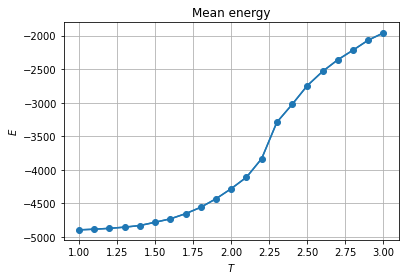

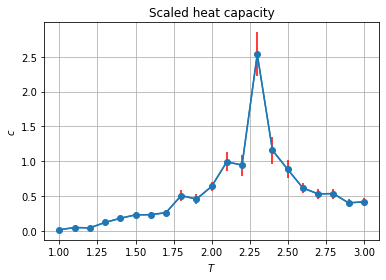

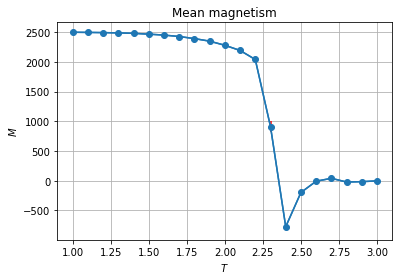

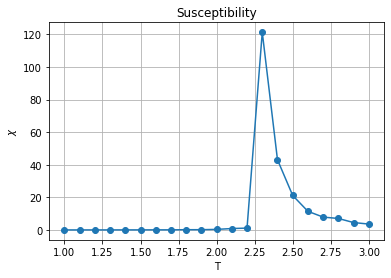

In [207]:
plt.errorbar(Ts, E_mean_data, yerr=E_error, ecolor='red')  # very small
plt.plot(Ts, E_mean_data, '-o')
plt.title('Mean energy')
plt.grid()
plt.xlabel(r'$T$')
plt.ylabel(r'$E$')
plt.savefig('glauber_energy_fig.png')
plt.show()

plt.errorbar(Ts, c_data, yerr=c_error, ecolor='red')
plt.plot(Ts, c_data, '-o')
plt.title('Scaled heat capacity')
plt.grid()
plt.xlabel(r'$T$')
plt.ylabel(r'$c$')
plt.savefig('glauber_c_fig.png')
plt.show()

plt.errorbar(Ts, M_mean_data, yerr=M_error, ecolor='red')  # very small
plt.plot(Ts, M_mean_data, '-o')
plt.title('Mean magnetism')
plt.grid()
plt.xlabel(r'$T$')
plt.ylabel(r'$M$')
plt.savefig('glauber_magnetism_fig.png')
plt.show()

plt.plot(Ts, chi_data, '-o')
plt.title(r'Susceptibility')
plt.grid()
plt.xlabel('T')
plt.ylabel(r'$\chi$')
plt.savefig('glauber_chi_fig.png')
plt.show()

### Glauber interpretation

Energy and magnetism plots are behave as would be expected for a non-infinite amount of setps. Both Scaled heat capacity and susceptibility have (visually) peaks $T=2.3$ which is interpret to be the critical temperature. Furthermore, the magnetism plot does also behave as if it would have critical temperature around $T=2.3$. 

## Kawasaki dynamics

In [208]:
kb = 1
xlen = 50
ylen = 50
N = xlen * ylen

In [209]:
data = pd.read_csv('data50x50kawasaki_energy-calc-correction_1000nsweeps.csv', converters={'energy data': pd.eval, 'magnetism data': pd.eval})
data.head()

,T,energy data,magnetism data
0,1.0,"[-4784.0, -4788.0, -4788.0, -4788.0, -4788.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.1,"[-4702.0, -4702.0, -4702.0, -4702.0, -4702.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1.2,"[-4662.0, -4642.0, -4634.0, -4638.0, -4634.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1.3,"[-4554.0, -4574.0, -4614.0, -4574.0, -4590.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1.4,"[-4580.0, -4592.0, -4608.0, -4628.0, -4604.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [217]:
Ts = data['T'].to_list()
nTs = len(Ts)
E_data = data['energy data'].to_list()
c_data = []
M_data = data['magnetism data'].to_list()
chi_data = []

for i in range(nTs):
    c_data.append(scaled_heat_capacity(E_data[i], N, kb, Ts[i]))
    chi_data.append(chi(M_data[i], N, kb, Ts[i]))
E_mean_data = [E_i.mean() for E_i in E_data]
M_mean_data = [M_i.mean() for M_i in M_data]


method = 'bootstrap'  # bootstrap or jacknife
c_error = []
for i in range(nTs):
    if method == 'bootstrap':
        k = 1000
        c_error.append(bootstrap(k, E_data[i], Ts[i], N, kb))
    elif method == 'jacknife':
        c_error.append(jackinfe(E_data[i], Ts[i], N, kb))

# If energy measurements are assumed uncorrelated
E_error = []
for i in range(nTs):
    E_error.append(mean_STD(E_data[i]))

kawasaki_results = pd.DataFrame({'T': Ts, 'Energy': E_mean_data, 'Energy error': E_error, 
                              'c': c_data, 'c error': c_error})
kawasaki_results.to_csv('kawasaki_run_results.csv')
kawasaki_results.head()

,T,Energy,Energy error,c,c error
0,1.0,-4749.230769,1.724001,0.106998,0.018387
1,1.1,-4663.010989,1.764215,0.092602,0.015686
2,1.2,-4620.197802,1.947054,0.094775,0.011502
3,1.3,-4616.461538,2.619934,0.146217,0.019082
4,1.4,-4567.340659,2.453983,0.110609,0.014133


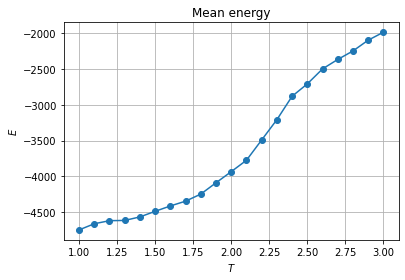

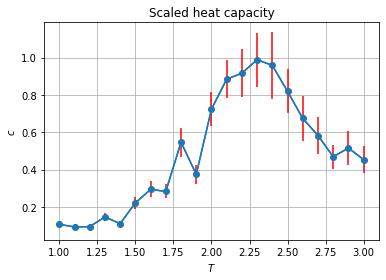

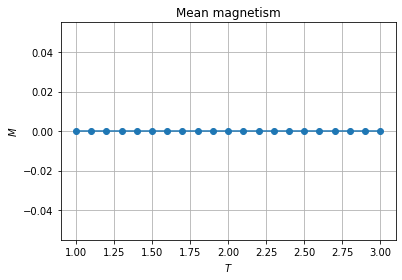

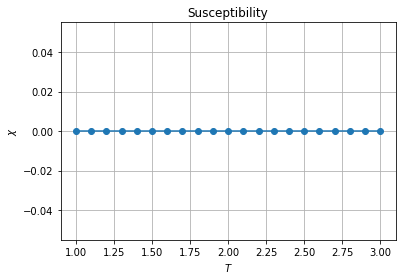

In [219]:
plt.plot(Ts, E_mean_data, '-o')
plt.title('Mean energy')
plt.grid()
plt.xlabel(r'$T$')
plt.ylabel(r'$E$')
plt.savefig('kawasaki_energy_fig.png')
plt.show()

plt.errorbar(Ts, c_data, yerr=c_error, ecolor='red')
plt.plot(Ts, c_data, '-o')
plt.title('Scaled heat capacity')
plt.grid()
plt.xlabel(r'$T$')
plt.ylabel(r'$c$')
plt.savefig('kawasaki_c_fig.png')
plt.show()

plt.plot(Ts, M_mean_data, '-o')
plt.title('Mean magnetism')
plt.grid()
plt.xlabel(r'$T$')
plt.ylabel(r'$M$')
plt.show()

plt.plot(Ts, chi_data, '-o')
plt.title('Susceptibility')
plt.grid()
plt.xlabel(r'$T$')
plt.ylabel(r'$\chi$')
plt.show()

### Kawasaki interpretation

As can be expected magnetisation and susceptibility stay constant (zero because of set initial conditions). Energy behaves as would be expected. Scaled heat capacity again has a peak (visually) around $T=2.3$ which agrees with the results for glauber dynamics. It is to be noted that the error's are larger here compared to the glauber dynamics results.